In [1]:
import numpy as np
import matplotlib.pyplot as plt


class Neural_Network:
    def __init__(self, structure, eta=0.0001):
        assert len(structure) == 4
        self.structure = structure
        self.input_dim = self.structure[0]
        self.hidden_dim1 = self.structure[1]
        self.hidden_dim2 = self.structure[2]
        self.output_dim = self.structure[3]
        self.eta = eta
        self.errors = []

        self.W1 = 2 * np.random.random((self.input_dim, self.hidden_dim1)) - 1
        self.W2 = 2 * np.random.random((self.hidden_dim1, self.hidden_dim2)) - 1
        self.W3 = 2 * np.random.random((self.hidden_dim2, self.output_dim)) - 1

        self.weights = [self.W1, self.W2, self.W3]
        self.activations = [None, None, None, None]

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, s):
        return s * (1 - s)
    
    def forward(self, x):
        self.activations[0] = x.copy()
        self.activations[1] = self.sigmoid(np.dot(self.activations[0], self.weights[0]))
        self.activations[2] = self.sigmoid(np.dot(self.activations[1], self.weights[1]))
        self.activations[3] = self.sigmoid(np.dot(self.activations[2], self.weights[2]))
        return self.activations[3]

    def backward(self, y):
        epsilon = [None] * 4
        delta = [None] * 4

        epsilon[3] = y - self.activations[3]
        delta[3] = epsilon[3] * self.sigmoid_derivative(self.activations[3])

        epsilon[2] = np.dot(delta[3], self.weights[2].T)
        delta[2] = epsilon[2] * self.sigmoid_derivative(self.activations[2])

        epsilon[1] = np.dot(delta[2], self.weights[1].T)
        delta[1] = epsilon[1] * self.sigmoid_derivative(self.activations[1])

        for i in range(3):
            self.weights[i] += self.eta * np.dot(self.activations[i].T, delta[i+1])

    def train(self, train_x, train_y):
        self.forward(train_x)
        self.backward(train_y)
        self.errors.append(self.loss(train_y, self.activations[3]))

    def loss(self, ty, y):
        return np.mean(np.square(ty - y))

    def evaluate(self, test_x, test_y):
        predictions = self.forward(test_x)
        predictions = np.argmax(predictions, axis=1)
        targets = np.argmax(test_y, axis=1)
        accuracy = np.mean(predictions == targets)
        return accuracy


In [2]:
def lrp(neural_network, x):
    # Inicjalizacja wyników istotności.
    relevance_scores = np.ones(10)

    # Propagacja wyników istotności wstecz
    for i in range(2, -1, -1):
        relevance_scores = lrp_layer(neural_network.weights[i], neural_network.activations[i], relevance_scores)

    # Normalizacja
    relevance_scores /= np.sum(relevance_scores)

    # Ocena wag wejscia
    input_synaptic_weights = relevance_scores * x
    return input_synaptic_weights

def lrp_layer(weights, activations, relevance_scores):
    # Obliczanie wyników istotności dla wyjścia warstwy.
    output_relevance_scores = relevance_scores * np.dot(activations, weights)

    # Propagacja wyników istotności do wejść warstwy.
    input_relevance_scores = np.dot(output_relevance_scores, weights.T)

    return input_relevance_scores


In [3]:
from keras.datasets import mnist
from keras.utils import to_categorical

# Załadowanie MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Wybór mniejszej liczby przykłądów
random_indices = np.random.choice(x_train.shape[0], size=30000, replace=False)
x_train = x_train[random_indices]
y_train = y_train[random_indices]

# TRAIN - przekształcenia
x_train = x_train.reshape((x_train.shape[0], -1)).astype(np.float64)
x_train /= 255.

y_train = to_categorical(y_train) 

# TEST - przekształcenia
x_test = x_test.reshape((x_test.shape[0], -1)).astype(np.float64)
x_test /= 255.

y_test = to_categorical(y_test) 

# Zmiana wartości na 0 i 1 
x_train[x_train >= 0.35] = 1
x_train[x_train < 0.35] = 0
x_test[x_test >= 0.35] = 1
x_test[x_test < 0.35] = 0

In [4]:
# ##TWORZENIE MODELU
# neural_network = Neural_Network(structure=[784, 64, 32, 10])

# # UCZENIE
# num_epochs = 10000
# for epoch in range(num_epochs):
#     neural_network.train(x_train, y_train)
#     accuracy = neural_network.evaluate(x_test, y_test)
#     print(f"Epoch {epoch+1}/{num_epochs} - Accuracy: {accuracy}")
    
# ##ZAPISANIE MODELU
# import pickle

# with open("neural_network5.pkl", "wb") as f:
#     pickle.dump(neural_network, f)

In [5]:
#WCZYTANIE MODELU
import pickle
# Load the neural network
with open("neural_network.pkl", "rb") as f:
    neural_network = pickle.load(f)


In [6]:
import sys
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QPushButton, QGridLayout
from PyQt5.QtGui import QColor
from PyQt5.QtCore import Qt
import random


class Grid(QWidget):

    def __init__(self, height, width, cell_size):
        super().__init__()    
        self.width = width
        self.height = height
        self.cell_size = cell_size
        
        ##################################################################
        #Tworzenie siatki i przycisków
        self.grid = [[False for _ in range(width)] for _ in range(height)]
        self.buttons = [[QPushButton(self) for _ in range(width)] for _ in range(height)]


        #Siatka przycisków
        for row in range(height):
            for col in range(width):
                self.buttons[row][col].setStyleSheet(f"background-color: white; border: 1px solid black")
                self.buttons[row][col].setFixedSize(cell_size, cell_size)
                self.buttons[row][col].pressed.connect(self.make_toggle(row, col))
                self.buttons[row][col].released.connect(self.make_toggle(row, col))

        
        #Dolny panel
        self.random_button = QPushButton("Losuj liczbę", self)
        self.random_button.clicked.connect(self.get_digit)
        
        self.recognize_button = QPushButton("Rozpoznaj", self)
        self.recognize_button.clicked.connect(self.recognize)
        
        self.weights_button = QPushButton("Istotność", self)
        self.weights_button.clicked.connect(self.weights)
        
        
        self.clear_button = QPushButton("Czyść", self) 
        self.clear_button.clicked.connect(self.clear_grid)  
        
        self.noise_button = QPushButton("Szum", self)
        self.noise_button.clicked.connect(self.add_noise)
        
        
        self.left_button = QPushButton('◄', self)
        self.left_button.clicked.connect(self.move_left) 
        
        self.right_button = QPushButton('►', self)
        self.right_button.clicked.connect(self.move_right) 
        
        self.up_button = QPushButton('▲', self)
        self.up_button.clicked.connect(self.move_up) 
        
        self.down_button = QPushButton('▼', self)
        self.down_button.clicked.connect(self.move_down) 
        
        
        ################################################################
        # LAYOUT GRID
        self.grid_layout = QGridLayout()
        self.grid_layout.setSpacing(0)
        for row in range(height):
            for col in range(width):
                self.grid_layout.addWidget(self.buttons[row][col], row, col)

        # BUTTON LAYOUT
        self.button_container = QWidget() 
        self.button_layout = QGridLayout()

        self.button_layout.addWidget(self.random_button, self.height + 1, 0)
        self.button_layout.addWidget(self.recognize_button, self.height + 1, 1)
        self.button_layout.addWidget(self.weights_button, self.height + 1, 2)
        
        self.button_layout.addWidget(self.clear_button, self.height + 2, 0)
        self.button_layout.addWidget(self.noise_button, self.height + 2, 1)

        self.button_layout.addWidget(self.up_button, self.height + 1, 3)
        self.button_layout.addWidget(self.left_button, self.height + 2, 2)
        self.button_layout.addWidget(self.right_button, self.height + 2, 4)
        self.button_layout.addWidget(self.down_button, self.height + 2, 3)

        self.button_container.setLayout(self.button_layout)

        # ZŁĄCZENIE LAYOUTów
        self.main_layout = QGridLayout()
        self.main_layout.addLayout(self.grid_layout, 0, 0)  
        self.main_layout.addWidget(self.button_container, 1, 0)  

        self.setLayout(self.main_layout)
 
    ############################################################
    #Rysowanie na siatce
    
    def make_toggle(self, row, col):
        def toggle():
            if QApplication.mouseButtons() & Qt.LeftButton:
                self.grid[row][col] = 1
                button = self.buttons[row][col]
                button.setStyleSheet("background-color: black; border: 1px solid black")
                self.update_neighboring_buttons(row, col) 
        return toggle

    def update_neighboring_buttons(self, row, col):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  #góra, dół, lewo, prawo

        for dx, dy in directions:
            new_row, new_col = row + dx, col + dy
            if 0 <= new_row < self.height and 0 <= new_col < self.width:
                self.grid[new_row][new_col] = self.grid[row][col]
                button = self.buttons[new_row][new_col]
                if self.grid[new_row][new_col]:
                    button.setStyleSheet("background-color: black; border: 1px solid black")
                else:
                    button.setStyleSheet("background-color: white; border: 1px solid black")

    def mouseMoveEvent(self, event):
        pos = event.pos()
        button = self.childAt(pos)
        if button: 
            row, col = self.get_button_position(button)
            self.make_toggle(row, col)()

    def get_button_position(self, button):
        for row, button_row in enumerate(self.buttons):
            for col, button_col in enumerate(button_row):
                if button_col is button:
                    return row, col

                
    ########################################################
    #Funkcje dla przycisków
    
    #CZYŚĆ
    def clear_grid(self):  
        for row in range(self.height):
            for col in range(self.width):
                self.grid[row][col] = False
                self.buttons[row][col].setStyleSheet(f"background-color: white; border: 1px solid black")
                
    #SZUM
    def add_noise(self):
        for _ in range(50):
            row = random.randint(0, self.height-1)
            col = random.randint(0, self.width-1)
            if self.grid[row][col]:
                self.grid[row][col] = False
            else:
                self.grid[row][col] = True
            # self.grid[row][col] = not self.grid[row][col]
            color = "black" if self.grid[row][col] else "white"
            self.buttons[row][col].setStyleSheet(f"background-color: {color}; border: 1px solid black")
        
    #LOSUJ LICZBĘ (pozyskanie liczby na siatkę)
    def get_digit(self):
        digit = random.randint(0, len(x_test) - 1)
        digit_sample = x_test[digit].reshape(28,28)
        self.set_grid(digit_sample)
        
    def set_grid(self, digit_sample):
        for row in range(self.height):
            for col in range(self.width):
                if digit_sample[row][col] >0:
                    self.grid[row][col] = 1
                    self.buttons[row][col].setStyleSheet("background-color: black; border: 1px solid black")
                else:
                    self.grid[row][col] = 0
                    self.buttons[row][col].setStyleSheet("background-color: white; border: 1px solid black")
         
    #ROZPOZNAJ
    def recognize(self):
        predicted_number_vec = neural_network.forward(np.array(self.grid).reshape(-1, 784))
        predicted_number = np.argmax(predicted_number_vec)
        print("Przewidywana liczba:", predicted_number) 
        
        # Wykres predykcji dla 10 neuronów 
        fig = plt.figure(figsize=(3, 2)) 
        
        neuron_indices = range(10)
        plt.bar(neuron_indices, predicted_number_vec.squeeze(), color='green')
        plt.xticks(neuron_indices) 
        
        plt.show()
        
    #WAGI (obliczenie wag dla wyjscia)     
    def weights(self):
        neural_network.forward(np.array(self.grid).reshape(-1, 784))
        input_synaptic_weights = lrp(neural_network, np.array(self.grid).reshape(-1, 784))
        
        input_synaptic_weights = np.abs(input_synaptic_weights.reshape((28, 28)))

        #Wykres wag
        max_abs_value = np.max(np.abs(input_synaptic_weights))


        fig = plt.figure(figsize=(3, 3))
        plt.imshow(input_synaptic_weights, cmap='binary', vmin=0, vmax=max_abs_value, interpolation='nearest')
        plt.colorbar()
        plt.show()

    #############################################################
    #PRZENOSZENIE WZORU 
    def move_left(self):
        if any(self.grid[row][0] for row in range(self.height)):
            return

        for row in range(self.height):
            for col in range(1, self.width):
                self.grid[row][col - 1] = self.grid[row][col]
                self.grid[row][col] = 0

        self.update_buttons()

    def move_right(self):
        if any(self.grid[row][self.width - 1] for row in range(self.height)):
            return

        for row in range(self.height):
            for col in range(self.width - 2, -1, -1):
                self.grid[row][col + 1] = self.grid[row][col]
                self.grid[row][col] = 0

        self.update_buttons()

    def move_up(self):
        if any(self.grid[0]):
            return

        for col in range(self.width):
            for row in range(1, self.height):
                self.grid[row - 1][col] = self.grid[row][col]
                self.grid[row][col] = 0

        self.update_buttons()

    def move_down(self):
        if any(self.grid[-1]):
            return

        for col in range(self.width):
            for row in range(self.height - 1, 0, -1):
                self.grid[row][col] = self.grid[row - 1][col]
            self.grid[0][col] = 0

        self.update_buttons()

    def update_buttons(self):
        for row in range(self.height):
            for col in range(self.width):
                if self.grid[row][col] == 1:
                    self.buttons[row][col].setStyleSheet("background-color: black; border: 1px solid black")
                else:
                    self.buttons[row][col].setStyleSheet("background-color: white; border: 1px solid black")


In [7]:
class MainWindow(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setGeometry(1300, 100, 400, 400)
        self.setWindowTitle("Digit Classifier")
        self.Grid = Grid(28, 28, 20)
        self.setCentralWidget(self.Grid)
        self.show()
        

Przewidywana liczba: 3


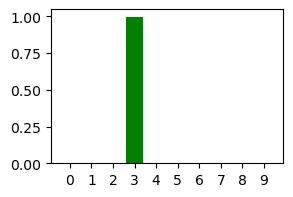

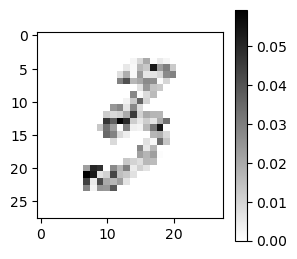

Przewidywana liczba: 9


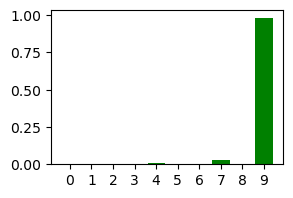

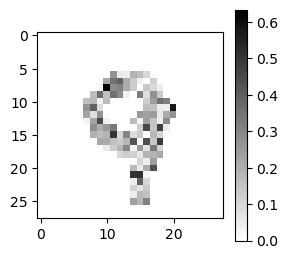

Przewidywana liczba: 5


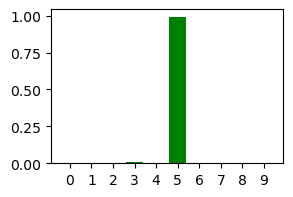

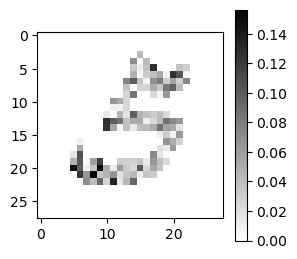

Przewidywana liczba: 4


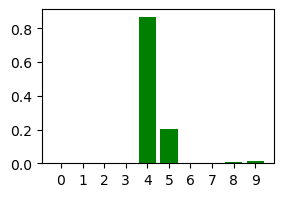

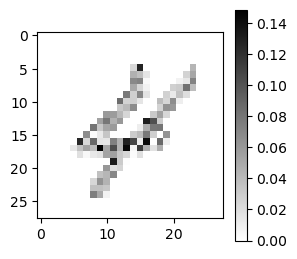

Przewidywana liczba: 5


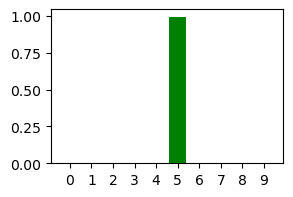

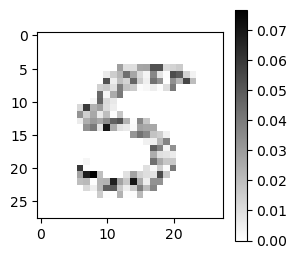

Przewidywana liczba: 8


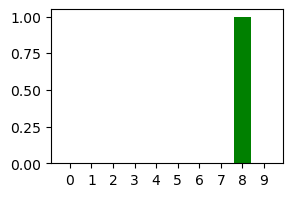

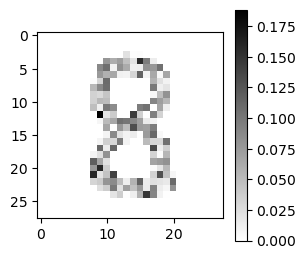

In [ ]:
if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = MainWindow()
    window.show()
    sys.exit(app.exec())
    